1. [Ingest Quandl bundle in Quantopian Zipline](#Ingest-Quandl-bundle-in-Quantopian-Zipline)

1. [Time Series Analysis](#Time-Series-Analysis)

1. [Feature's Engineering](#Feature's-Engineering)
    1. [Technical Analysis](#Technical-Analysis)
    1. [Sentiment Analysis](#Sentiment-Analysis)
    
1. [First Trading Algorithm](#First-Trading-Algorithm)
    1. [Trading Strategy Backtesting](#Trading-Strategy-Backtesting)    

1. [Model Prediction](#Model-Prediction)
    1. [Linear Model](#Linear-Model)
    1. [GARCH Model](#GARCH-Model) 
    1. [Decision Trees and Random Forests](#Decision-Trees-and-Random-Forests) 
    1. [Gradient Boosting and Adaboost Models](#Gradient-Boosting-and-Adaboost-Models)
    1. [K-Neighbors](#K-Neighbors) 
    1. [Neural Networks](#Neural-Networks)
    1. [Deep Learning and LSTM](#Deep-Learning-and-LSTM)   

# Ingest Quandl bundle in Quantopian Zipline
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Zipline has an included bundle from Quandl (financial data provider), which reads equity data from Quandl. To be able to use free Quandl data, you need to have an account and get an API key get in order to download the data. On the command line you should run: <br>
```javascript
QUANDL_API_KEY=your_quandl_api_key zipline ingest -b quandl
```

and then type:

In [4]:
!zipline bundles

csvdir <no ingestions>
ibex35_stock_data 2020-08-07 16:40:30.271346
quandl 2020-08-11 11:21:20.009622
quantopian-quandl <no ingestions>


The quandl bundle has been ingested with success. <br>
Let's now proceed with importing the necessary libraries.

In [3]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [4]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
%watermark --iversions

zipline 1.4.0
pandas  0.22.0
numpy   1.14.2



## Load data bundle

Next, we will proceed with loading our bundle. For such purpose, the [video](https://subscription.packtpub.com/video/application_development/9781789951165) <i>Machine Learning for Algorithmic Trading Bots in Python</i> by Mustafa Qamar-ud-Din, has been of great help. <br>
As usual, let's first import necessary libraries plus additional load extensions in the IPython magic. Check this [GitHub thread](https://github.com/quantopian/zipline/issues/1542) for more information.<br>
On how to proceed with this section, this other [GitHub thread](https://github.com/quantopian/zipline/issues/1579) might also be worth exploring.

In [3]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

First, as abovementioned, we load our quandl bundle.

In [4]:
bundle_data = bundles.load('quandl')

In [5]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


Second, we initialise our DataPortal interface with the below mandatory arguments.
We shall beforehand define our end_date argument and check for the first trading day.

In [6]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [7]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [8]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

Third, we will build our DataFrame for further analysis and feature preprocessing. For such purpose, we shall use a get_history_window method on the data portal interface.

In [9]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [10]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7000,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [12]:
df.tail()

,Equity(8 [AAPL])
2018-03-21 00:00:00+00:00,175.04
2018-03-22 00:00:00+00:00,170.00
2018-03-23 00:00:00+00:00,168.39
2018-03-26 00:00:00+00:00,168.07
2018-03-27 00:00:00+00:00,173.68


We now index our date column and rename the stock column after the ticker's name.

In [13]:
df.index = pd.DatetimeIndex(df.index)

The name of the column <i>Equity(0 [AAPL])</i> is a Pandas object (more concretely, a 'zipline.assets._assets.Equity' object). When we attempt to rename it, a TypeError is displayed (Index does not support mutable operations). As such, we will create another identical column thus passing a list method to the column name and then drop the original column.

In [14]:
df['close'] = df[list(df.columns)[0]]

In [15]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-06-15 00:00:00+00:00,39.75
1990-06-18 00:00:00+00:00,39.25
1990-06-19 00:00:00+00:00,39.00
1990-06-20 00:00:00+00:00,39.88
1990-06-21 00:00:00+00:00,40.00


# Time Series Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In this section, we will delve into the DataFrame statistical properties and perform some visualisations.

In [15]:
df.describe()

,REP
count,5226.000000
mean,17.577431
std,4.391224
min,6.030000
25%,14.410000
50%,17.137500
75%,20.500000
max,30.350000


## Converting prices to returns

As we shall see in the visualisation, asset returns are non-stationnary, neither in mean nor in variance. We may attempt to render them stationnary by converting prices to returns, both simple returns (aggregating to assets) and log-returns (aggregating over time). <br>
Stationarity is an important statistical property of regressors in order to infer consistent parametric estimators. 

In [16]:
df['simple_rtn'] = df.close.pct_change()
df['log_rtn'] = np.log(df.close/df.close.shift(1))

In [28]:
df.head()

,close,simple_rtn,log_rtn
1990-06-18 00:00:00+00:00,39.25,-0.012579,-0.012658
1990-06-19 00:00:00+00:00,39.00,-0.006369,-0.006390
1990-06-20 00:00:00+00:00,39.88,0.022564,0.022313
1990-06-21 00:00:00+00:00,40.00,0.003009,0.003005
1990-06-22 00:00:00+00:00,42.00,0.050000,0.048790


In [18]:
df = df.dropna() # We drop NAs

## Canddlestick visualisation

[Text(0, 0.5, 'Log returns (%)'), Text(0.5, 0, 'date')]

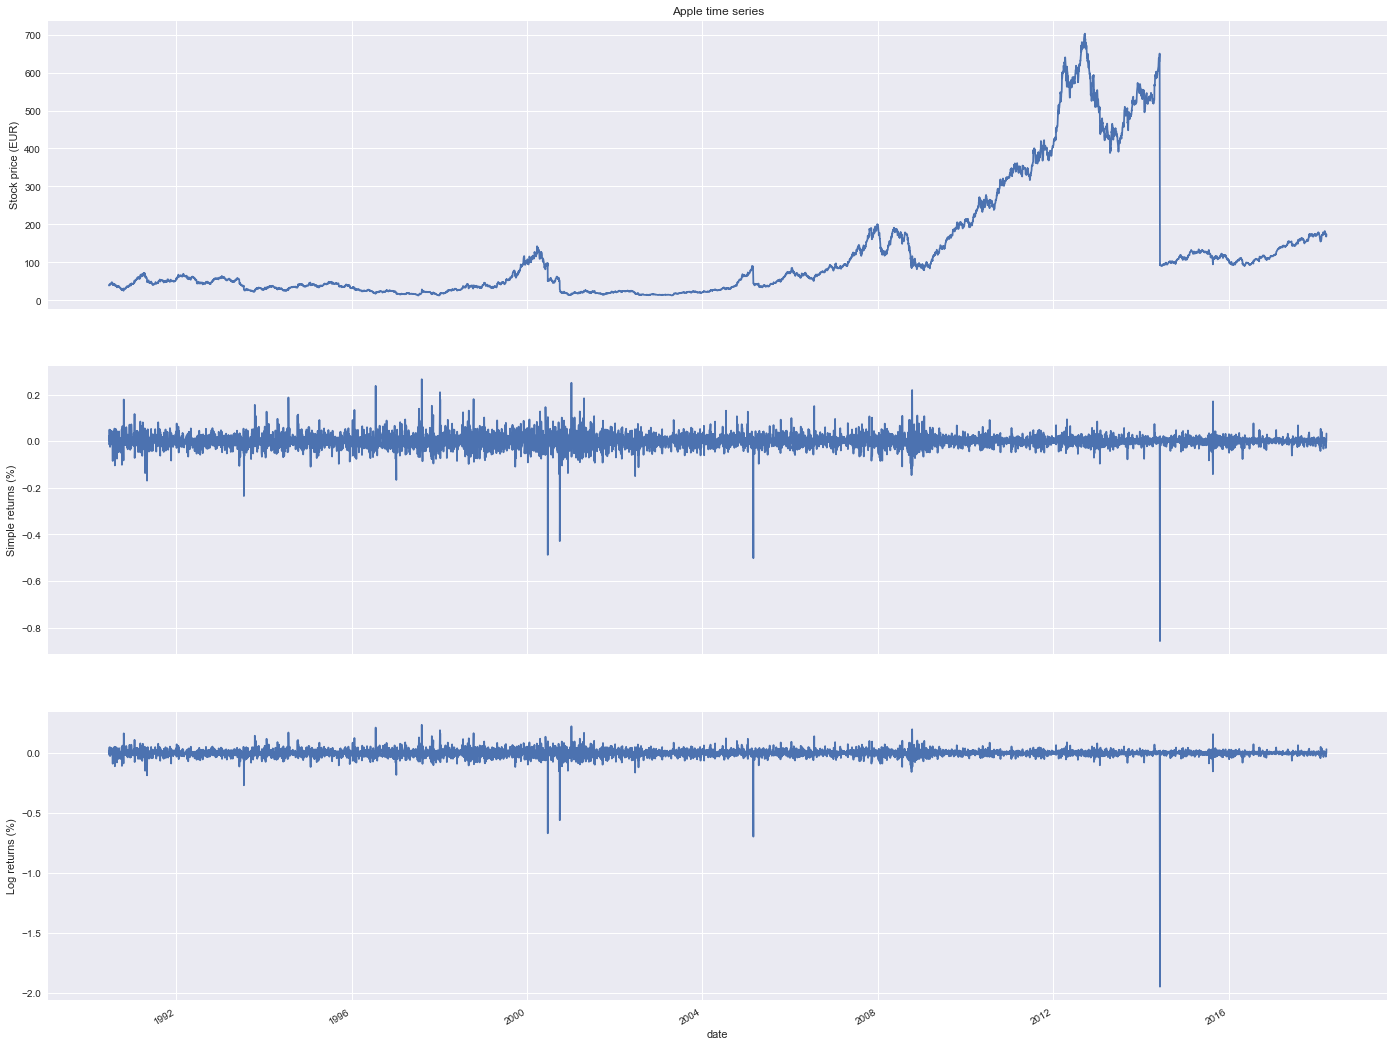

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

df.close.plot(ax=ax[0])
ax[0].set(title = 'Apple time series',
          ylabel = 'Stock price (EUR)')
    
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'date', 
          ylabel = 'Log returns (%)')

In [21]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import chart_studio.plotly as py

init_notebook_mode()

ImportError: No module named 'cufflinks'

In [60]:
# Set up configuration: run it once
cf.set_config_file(world_readable=True, theme='pearl', 
                   offline=True)

## Stylized facts of asset returns

In [23]:
# Import necessary libraries
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

**1.- Non Gaussian distribution of returns**

In [24]:
# Calculate the normal Probability Density Function (PDF)
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma) 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Q-Q plot')

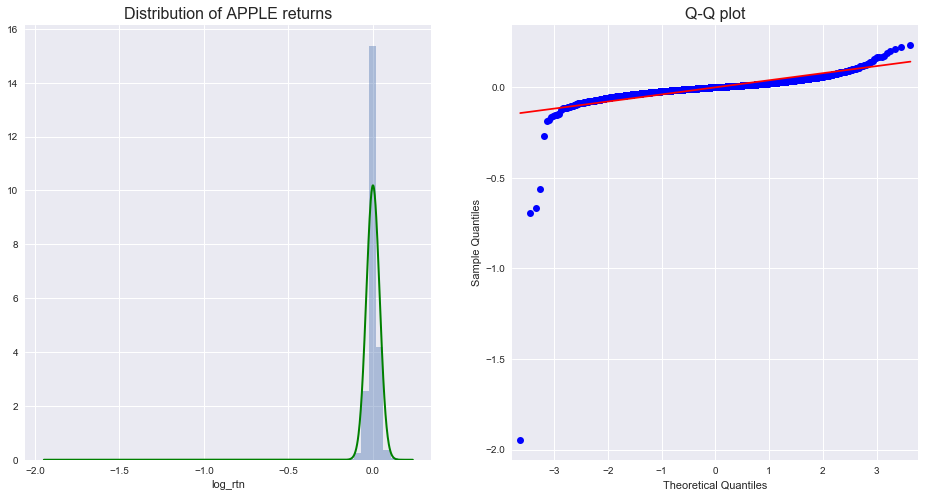

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0]) 
ax[0].set_title('Distribution of APPLE returns', fontsize=16) 
ax[0].plot(r_range, norm_pdf, 'g', lw=2)
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

In [26]:
# Print the summary statistics of the log returns

jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print('Mean: {:.4f}'.format(df.log_rtn.mean()))
print('Median: {:.4f}'.format(df.log_rtn.median()))
print('Min: {:.4f}'.format(df.log_rtn.min()))
print('Max: {:.4f}'.format(df.log_rtn.max()))
print('Standard Deviation: {:.4f}'.format(df.log_rtn.std()))
print('Skewness: {:.4f}'.format(df.log_rtn.skew()))
print('Kurtosis: {:.4f}'.format(df.log_rtn.kurtosis())) 
print('Jarque-Bera statistic: {:.2f} with p-value: {:.2f}'.format(jb_test[0], jb_test[1]))

---------- Descriptive Statistics ----------
Range of dates: 1990-06-18 - 2018-03-27
Number of observations: 6995
Mean: 0.0002
Median: 0.0003
Min: -1.9475
Max: 0.2361
Standard Deviation: 0.0392
Skewness: -19.4133
Kurtosis: 908.2773
Jarque-Bera statistic: 240538900.68 with p-value: 0.00


The log-returns series doest not match a normal gaussian distribution but more of a t-distribution, that is values centered around the mean and fat tails, meaning the presence of outliers (which can also be seen in the Q-Q plot). Actually, the distribution is leptokurtic (excess kurtosis of 3) implying the aforementioned profusion of outliers. In turn, the distribution is fairly symmetrical despite a negative skewness (positive log-returns bar count greater than negative ones). <br>
So far, this distribution complies with regular financial series.

**2.- Volatility Clustering**

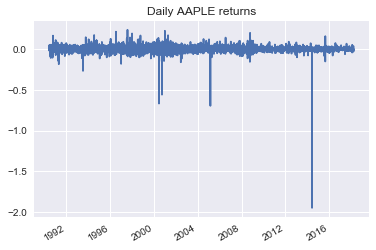

In [29]:
df.log_rtn.plot(title='Daily AAPLE returns')

We see that there are volatility clusters along the time axis.

**3.-Autocorrelation**

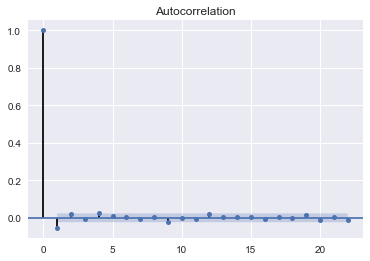

In [30]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                      lags=22, # A month
                      alpha=0.05)

We can assume this test is statistically significant for few values lie outside the confidence intervals. We can conclude there is no autocorrelation in log-returns lags. <br>
Let's test ACF in squared and absolute log-returns values.

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

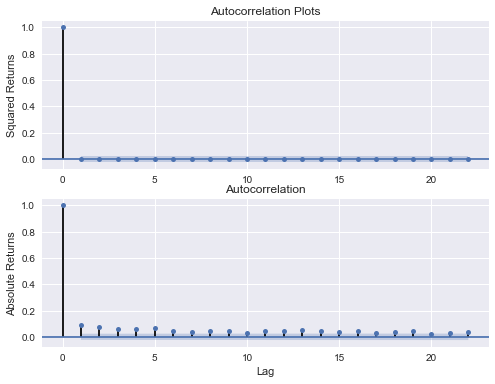

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=22, 
                      alpha=0.05, ax = ax[0])

ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=22, 
                      alpha=0.05, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

There is a discrete decaying autocorrelation in squared and absolute log-returns. We will therefore include new lagged variables in our DataFrame that may influence our regressor.

# Feature's Engineering
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In this section, we shall deal with simple returns and enrich our DataFrame with new variables. <br>
In finance, there are three important sources of data for quantitative analysis: <br>
<ol>
    <li>Technical data (OHLCV)</li>
    <li>Fundamental Analysis (companies' value)</li>
    <li>Alternative Analysis (sentiment analysis, geolocalisation, etc)</li>
</ol> 
Through <b>technical analysis</b>, we shall look into historical patterns that may reproduce in the future.
<b>Fundamental analysis</b> is in turn useful to assess value indicators of listed companies that may guide our investment decisions.
<b>Alternative analysis</b> may provide additionnal explanatory sense to our target. Interestingly enough, we shall webscrape Twitter to retrieve how sentiment analysis impacts the value's stock.

## Technical Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In [32]:
df = df.drop(columns=['simple_rtn', 'log_rtn'])

In [33]:
df['5d_close_future_pct'] = df['close'].shift(-5).pct_change(5).dropna()
df['5d_close_pct'] = df['close'].pct_change(5).dropna()

In [34]:
df = df.dropna()

In [35]:
df.head()

,close,5d_close_future_pct,5d_close_pct
1990-06-25 00:00:00+00:00,41.50,0.072289,0.057325
1990-06-26 00:00:00+00:00,41.75,0.051018,0.070513
1990-06-27 00:00:00+00:00,40.75,0.073620,0.021815
1990-06-28 00:00:00+00:00,42.75,0.017544,0.068750
1990-06-29 00:00:00+00:00,43.00,0.046512,0.023810


We will now create technical indicators derived from daily prices, namely moving average and relative strength indicators. <br>
Definition of moving average and RSI indicators:
<ul>
    <li> Moving Average</li>
    $\ MA = $
    <li> Relative Strength Indicator</li>
        $ RSI = 100 - [\frac{100}{1 + \frac{AverageGain}{AverageLoss}}]$

In [36]:
import talib

feature_names = ['5d_close_pct']

for n in [14, 30, 50, 200]:
    # Moving Average
    df['ma' + str(n)] = talib.SMA(df['close'].values, timeperiod = n) / df['close']
    
    # Relative Strength Indicator
    df['rsi' + str(n)] = talib.RSI(df['close'].values, timeperiod = n)
    
    # Features'names list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


Let's now check for <b>correlation</b> (high correlation among features and target is preferred) and <b>feature importances</b>. We can analyse it visually with SHAP (see this [article](https://medium.com/@lucasramos_34338/visualizing-variable-importance-using-shap-and-cross-validation-bd5075e9063a)).

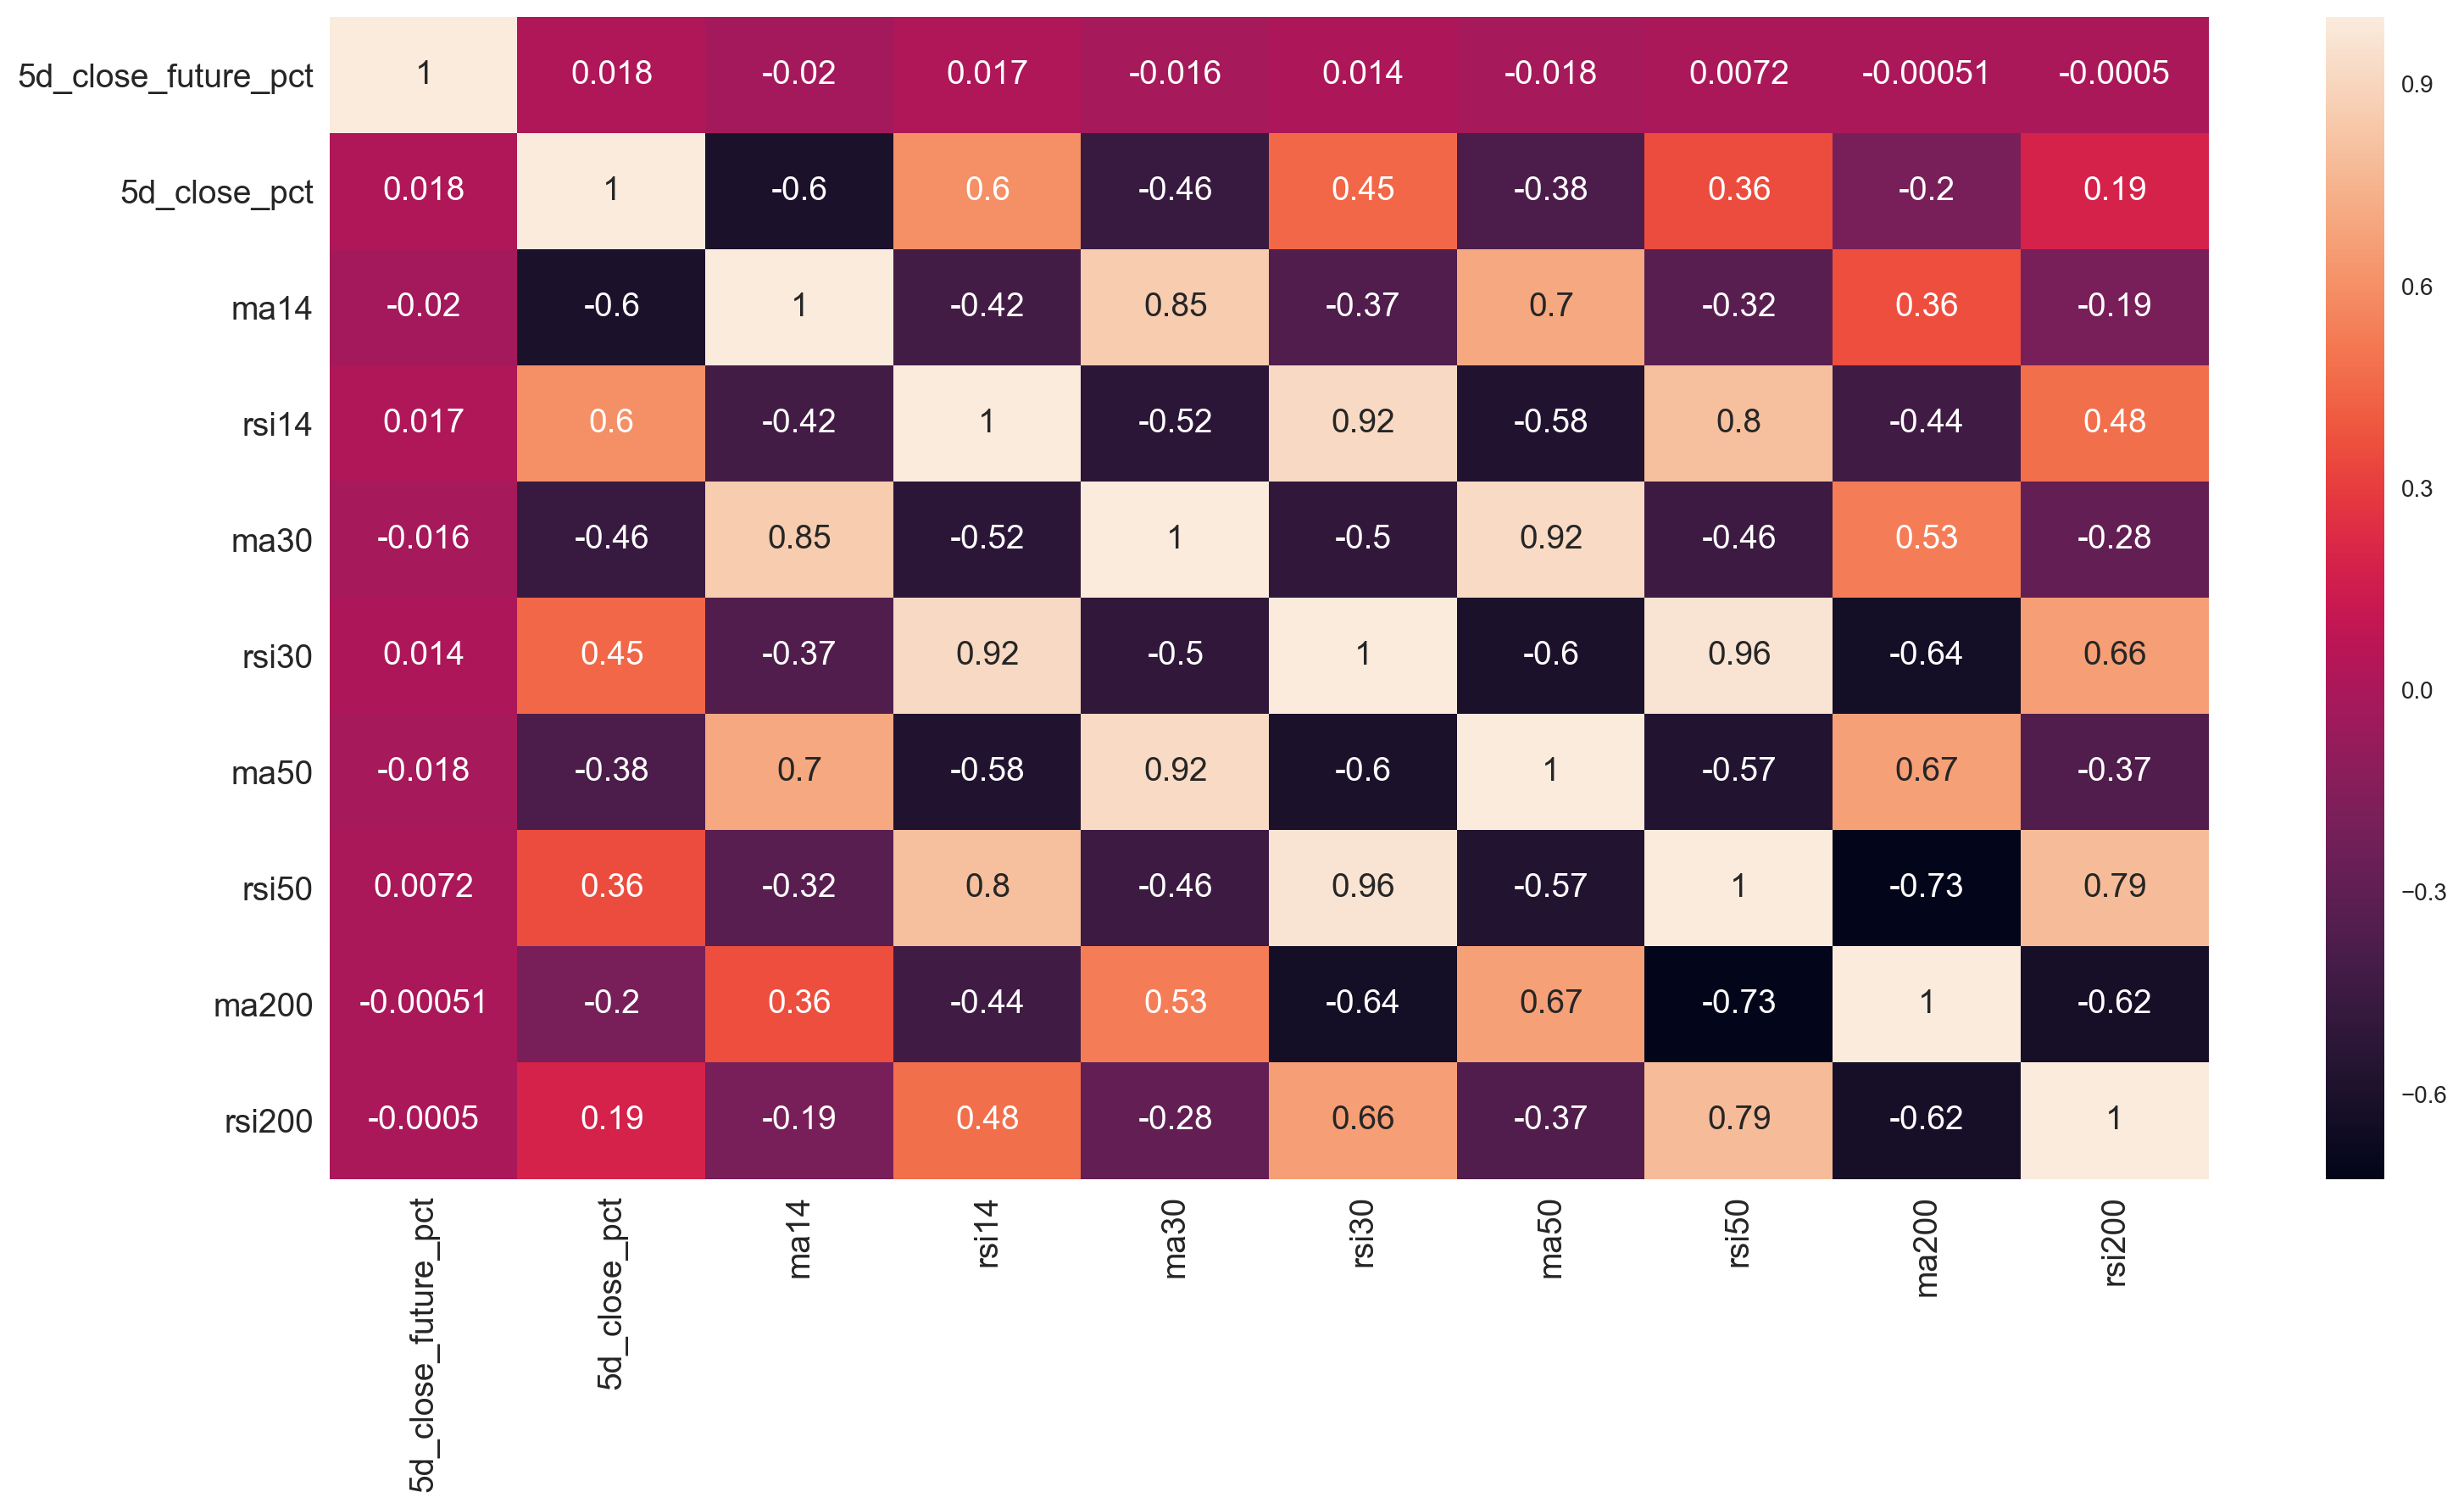

In [37]:
# Create features and targets
features = df[feature_names]
targets = df['5d_close_future_pct']

# New DataFrame with all variables
all_vars = ['5d_close_future_pct'] + feature_names
df2 = df[all_vars]

# Check for correlation between features and target and portray it in a sns heatmap
corr = df2.corr()

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
sns.heatmap(corr, annot= True, annot_kws = {"size": 14})
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  

As we can see, the correlation between the target and features is very weak and features might therefore fail to explain the target.<br>
Let's then explore sentiment analysis (...).

# First Trading Algorithm
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Before we pass on our first trading algorithm, we need to fix two issues on our zipline version 1.4:
<ol>
    <li>start time/end time are now pd.Timestamp data types</li>
    <li>the zipline library must now be told to explicitly not perform benchmarking</li>
</ol>

For more information, check this link to [Quantopian thread](https://www.quantopian.com/posts/new-book-on-quantopian-slash-zipline-backtesting-and-modeling).<br>

Our first trading algorithm is a buy and hold strategy of AAPLE stock from 2000 to 2018 with a capital base of 10.000 EUR. Python scripts are to be found in the following folders:
<ol>
    <li>buy_and_hold.py (strategies)</li>
    <li>run_zipline.py (strategies)</li>
    <li>main.py (project root directory)</li>
</ol>

The main.py script has been instructed to save performance in the following file:
<ul>
    <li>buy_and_hold.csv (reports folder)</li>
</ul>

We will now proceed to analyse results and backtest our strategy.
        

## Trading Strategy Backtesting
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

### Performance report

In [25]:
df = pd.read_csv('../reports/buy_and_hold.csv')

In [28]:
df = df.rename(columns={'Unnamed: 0':'date'}).set_index('date')

In [29]:
df.head()

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,excess_return,gross_leverage,long_exposure,long_value,longs_count,max_drawdown,max_leverage,net_leverage,orders,period_close,period_label,period_open,pnl,portfolio_value,positions,returns,sharpe,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03 21:00:00+00:00,111.94,NaN,0.000000,NaN,-0.068683,NaN,NaN,0.000,100000.000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0.000000,0.000000,0.000000,[{'created': Timestamp('2000-01-03 21:00:00+00...,2000-01-03 21:00:00+00:00,2000-01,2000-01-03 14:31:00+00:00,0.000,100000.000,[],0.000000,NaN,0.0,0.0,0,NaN,100000.000,0.0,0.0,1,[],0.0
2000-01-04 21:00:00+00:00,102.50,0.000587,-0.000052,0.124344,-0.139832,0.086594,0.006773,-10255.225,89744.775,10250.0,10250.0,0.0,0.102505,10250.0,10250.0,1,-0.000052,0.102505,0.102505,[{'created': Timestamp('2000-01-03 21:00:00+00...,2000-01-04 21:00:00+00:00,2000-01,2000-01-04 14:31:00+00:00,-5.225,99994.775,"[{'last_sale_price': 102.5, 'amount': 100, 'co...",-0.000052,-11.224972,0.0,0.0,0,-11.224972,100000.000,0.0,0.0,2,"[{'dt': Timestamp('2000-01-04 21:00:00+0000', ...",0.0
2000-01-05 21:00:00+00:00,104.00,0.013994,0.001448,-0.548092,-0.203733,0.063295,-0.049636,0.000,89744.775,10400.0,10400.0,0.0,0.103850,10400.0,10400.0,1,-0.000052,0.103850,0.103850,[],2000-01-05 21:00:00+00:00,2000-01,2000-01-05 14:31:00+00:00,150.000,100144.775,"[{'last_sale_price': 104.0, 'amount': 100, 'co...",0.001500,8.690675,0.0,0.0,0,253.962991,89744.775,10250.0,10250.0,3,[],0.0
2000-01-06 21:00:00+00:00,95.00,0.076026,-0.007552,-0.970191,-0.223912,0.382761,-0.195476,0.000,89744.775,9500.0,9500.0,0.0,0.095723,9500.0,9500.0,1,-0.008987,0.103850,0.095723,[],2000-01-06 21:00:00+00:00,2000-01,2000-01-06 14:31:00+00:00,-900.000,99244.775,"[{'last_sale_price': 95.0, 'amount': 100, 'cos...",-0.008987,-6.247419,0.0,0.0,0,-6.658428,89744.775,10400.0,10400.0,4,[],0.0
2000-01-07 21:00:00+00:00,99.50,0.080073,-0.003052,0.025698,-0.159227,1.078244,0.021742,0.000,89744.775,9950.0,9950.0,0.0,0.099805,9950.0,9950.0,1,-0.008987,0.103850,0.099805,[],2000-01-07 21:00:00+00:00,2000-01,2000-01-07 14:31:00+00:00,450.000,99694.775,"[{'last_sale_price': 99.5, 'amount': 100, 'cos...",0.004534,-1.891375,0.0,0.0,0,-2.373702,89744.775,9500.0,9500.0,5,[],0.0


In [37]:
df.columns

Index(['AAPL', 'algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'gross_leverage', 'long_exposure', 'long_value',
       'longs_count', 'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'sharpe', 'short_exposure', 'short_value',
       'shorts_count', 'sortino', 'starting_cash', 'starting_exposure',
       'starting_value', 'trading_days', 'transactions',
       'treasury_period_return'],
      dtype='object')

A brief explanation of some of the variables (and concepts):
<ul>
    <li><b>alpha</b>: our stock's performance compared to market's performance</li>
    <li><b>benchmark</b>: our benchmark here is the SPY exchange traded fund (500 most important listed companies in the USA)</li>
    <li><b>beta</b>: compares the volatility of our portfolio to market's volatility as a whole</li>
    
</ul>

Let's now plot some of these variables.

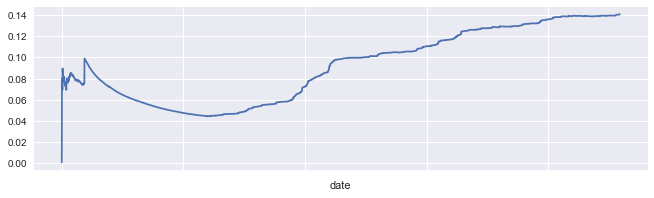

In [34]:
df.algo_volatility.plot(figsize=(11, 3));

<b>Alpha</b>: our stock fares similarly to the market. Actually, our strategy buy and hold is a very simple one and does not exploit short movements' opportunities.

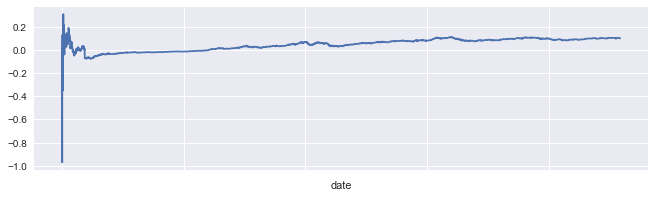

In [35]:
df.alpha.plot(figsize=(11, 3))

<b>Beta</b>: our stock is more volatile than the market

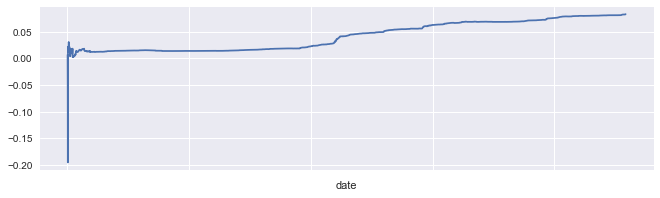

In [36]:
df.beta.plot(figsize=(11, 3))

Cumulative Returns

In [39]:
'${:.2f}'.format(df.capital_used.sum())

'$-10255.23'

In [40]:
'${:.2f}'.format(df.portfolio_value[-1])

'$561096.78'

In [41]:
'${:.2f}'.format(df.capital_used.sum() + df.portfolio_value[-1])

'$550841.55'

### Pyfolio

Pyfolio Backtest will be conducted in the next trading strategy.